In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

In [ ]:
# %%writefile ../src/deep_research_from_scratch/research_agent_full.py

"""
Full Multi-Agent Research System

This module integrates all components of the research system:
- User clarification and scoping
- Research brief generation  
- Multi-agent research coordination
- Final report generation

The system orchestrates the complete research workflow from initial user
input through final report delivery.
"""

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END

from deep_research_from_scratch.utils import get_today_str
from deep_research_from_scratch.prompts import final_report_generation_prompt
from deep_research_from_scratch.state_scope import AgentState, AgentInputState
from deep_research_from_scratch.research_agent_scope import clarify_with_user, write_research_brief
from deep_research_from_scratch.multi_agent_supervisor import supervisor_agent

# ===== Config =====

from langchain.chat_models import init_chat_model
writer_model = init_chat_model(model="gpt-4o-mini", max_tokens=16000) # model="anthropic:claude-sonnet-4-20250514", max_tokens=64000

# ===== FINAL REPORT GENERATION =====

from deep_research_from_scratch.state_scope import AgentState

async def final_report_generation(state: AgentState): 
    # async as we are await(ing) writer_model below
    # we cannot use await without async def
    """
    Final report generation node.
    
    Synthesizes all research findings into a comprehensive final report
    """
    
    notes = state.get("notes", [])
    
    findings = "\n".join(notes)

    final_report_prompt = final_report_generation_prompt.format(
        research_brief=state.get("research_brief", ""),
        findings=findings,
        date=get_today_str()
    )
    
    final_report = await writer_model.ainvoke([HumanMessage(content=final_report_prompt)])
    
    return {
        "final_report": final_report.content, 
        "messages": ["Here is the final report: " + final_report.content],
    }

# ===== GRAPH CONSTRUCTION =====
# Build the overall workflow
deep_researcher_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
deep_researcher_builder.add_node("clarify_with_user", clarify_with_user)
deep_researcher_builder.add_node("write_research_brief", write_research_brief)
deep_researcher_builder.add_node("supervisor_subgraph", supervisor_agent)
deep_researcher_builder.add_node("final_report_generation", final_report_generation)

# Add workflow edges
deep_researcher_builder.add_edge(START, "clarify_with_user")
deep_researcher_builder.add_edge("write_research_brief", "supervisor_subgraph")
deep_researcher_builder.add_edge("supervisor_subgraph", "final_report_generation")
deep_researcher_builder.add_edge("final_report_generation", END)

# Compile the full workflow
agent = deep_researcher_builder.compile()

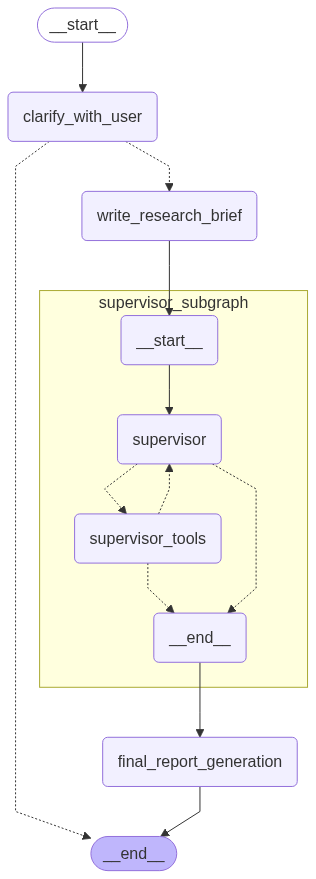

In [4]:
# Run the workflow
from utils import format_messages
from IPython.display import Image, display
from langgraph.checkpoint.memory import InMemorySaver
from deep_research_from_scratch.research_agent_full import deep_researcher_builder

checkpointer = InMemorySaver()
full_agent = deep_researcher_builder.compile(checkpointer=checkpointer)
display(Image(full_agent.get_graph(xray=True).draw_mermaid_png()))

In [5]:
from langchain_core.messages import HumanMessage
thread = {"configurable": {"thread_id": "1", "recursion_limit": 50}}
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Compare Gemini to OpenAI Deep Research agents.")]}, config=thread)
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by "Gemini"? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by "OpenAI Deep Research agents," do you mean OpenAI's advanced research models (like GPT-4/5) or a       │
│ specific research agent product? Please specify so I can provide an accurate comparison.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [6]:
result = await full_agent.ainvoke({"messages": [HumanMessage(content="Yes, Google's Gemini model and OpenAI's advanced research models (like GPT-4/5).")]}, config=thread)

Error in supervisor tools: Your request has been blocked due to excessive requests. Please reduce the rate of requests.


In [7]:
format_messages(result['messages'])

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Compare Gemini to OpenAI Deep Research agents.                                                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Could you clarify what you mean by "Gemini"? Are you referring to Google's Gemini AI model, or another system?  │
│ Also, by "OpenAI Deep Research agents," do you mean OpenAI's advanced research models (like GPT-4/5) or a       │
│ specific research agent product? Please specify so I can provide an accurate comparison.                        │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Yes, Google's Gemini model and OpenAI's advanced research models (like GPT-4/5).                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭───────────────────────────────────────────────────── 📝 AI ─────────────────────────────────────────────────────╮
│ Thank you for clarifying. You would like a comparison between Google's Gemini AI model and OpenAI's advanced    │
│ research models, such as GPT-4 and GPT-5. I have sufficient information to proceed and will now begin the       │
│ research and comparison process.                                                                                │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────── 🧑 Human ────────────────────────────────────────────────────╮
│ Here is the final report: # Comparative Analysis of Google's Gemini AI Model vs. OpenAI's GPT-4 and GPT-5       │
│                                                                                                                 │
│ This report provides a comprehensive comparison of Google's Gemini AI model and OpenAI's advanced models,       │
│ specifically GPT-4 and GPT-5. The analysis covers critical attributes such as model architecture, training data │
│ and methods, performance benchmarks, multimodal capabilities, scalability, safety and alignment features, and   │
│ real-world applications. Additional dimensions such as cost and accessibility are also considered.              │
│                                                                                                                 │
│ ## 1. Model Architecture and Training Methodology                                                               │
│                                                                                                                 │
│ ### 1.1 Google's Gemini AI Model                                                                                │
│ Google's Gemini AI revolves around a transformer-based architecture that advances the capabilities established  │
│ in its predecessors. This architecture is designed to enhance understanding and generation abilities across     │
│ various domains. Key features include:                                                                          │
│                                                                                                                 │
│ - **Scalability**: Gemini is built to handle increased computational demands with efficiency, employing         │
│ techniques such as weight sharing to optimize performance.                                                      │
│ - **Training Techniques**: Gemini utilizes a mix of supervised, unsupervised, and reinforcement learning        │
│ methods, effectively leveraging vast datasets sourced from the internet to refine its capabilities.             │
│                                                                                                                 │
│ ### 1.2 OpenAI's GPT-4 and GPT-5                                                                                │
│ OpenAI's GPT models also leverage a transformer-based architecture, with improvements made from version to      │
│ version.                                                                                                        │
│                                                                                                                 │
│ - **GPT-4**: Introduced significant enhancements in contextual understanding and generation with a large-scale  │
│ dataset that covers diverse topics.                                                                             │
│ - **GPT-5**: Expected to build upon GPT-4 with improved architecture, focusing on more nuanced language         │
│ understanding and generation capabilities through increased model parameters and refined training approaches.   │
│                                                                                                                 │
│ ### Comparison                                                                                                  │
│ While both Google and OpenAI utilize a transformer architecture, OpenAI focuses on scaling model parameters     │
│ substantially from GPT-4 to GPT-5, whereas Google's Gemini integrates weight sharing for efficiency without as  │
│ significant an increase in size.                                                                                │
│                                                                                                                 │
│ ## 2. Performance Benchmarks                           

In [8]:
from rich.markdown import Markdown
Markdown(result["final_report"])

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Comparative Analysis of Google's Gemini AI Model vs. OpenAI's GPT-4 and GPT-5                  ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

This report provides a comprehensive comparison of Google's Gemini AI model and OpenAI's advanced models,          
specifically GPT-4 and GPT-5. The analysis covers critical attributes such as model architecture, training data and
methods, performance benchmarks, multimodal capabilities, scalability, safety and alignment features, and          
real-world applications. Additional dimensions such as cost and accessibility are also considered.                 


                                  1. Model Architecture and Training Methodology                                   

                                           1.1 Google's Gemini AI Model                                            

Google's Gemini AI revolves around a transformer-based architecture that advances the capabilities established in  
its predecessors. This architecture is designed to enhance understanding and generation abilities across various   
domains. Key features include:                                                                                     

 • Scalability: Gemini is built to handle increased computational demands with efficiency, employing techniques    
   such as weight sharing to optimize performance.                                                                 
 • Training Techniques: Gemini utilizes a mix of supervised, unsupervised, and reinforcement learning methods,     
   effectively leveraging vast datasets sourced from the internet to refine its capabilities.                      

                                           1.2 OpenAI's GPT-4 and GPT-5                                            

OpenAI's GPT models also leverage a transformer-based architecture, with improvements made from version to version.

 • GPT-4: Introduced significant enhancements in contextual understanding and generation with a large-scale dataset
   that covers diverse topics.                                                                                     
 • GPT-5: Expected to build upon GPT-4 with improved architecture, focusing on more nuanced language understanding 
   and generation capabilities through increased model parameters and refined training approaches.                 

                                                    Comparison                                                     

While both Google and OpenAI utilize a transformer architecture, OpenAI focuses on scaling model parameters        
substantially from GPT-4 to GPT-5, whereas Google's Gemini integrates weight sharing for efficiency without as     
significant an increase in size.                                                                                   


                                             2. Performance Benchmarks                                             

                                      2.1 Accuracy and Reasoning Capabilities                                      

 • Gemini: Google touts advanced accuracy in natural language inference and reasoning tasks, attributing this to   
   extensive pre-training and fine-tuning strategies.                                                              
 • GPT-4 and GPT-5: OpenAI reports that GPT-4 achieves high benchmarks in both language generation and logical     
   reasoning tasks. Preliminary tests of GPT-5 suggest even greater accuracy.                                      

                                             2.2 Language Capabilities                                             

Both Gemini and GPT models excel in multilingual support, with Gemini reportedly having improved capabilities,     
particularly in lesser-known languages.